In [1]:
import pandas as pd
data = pd.read_csv('../raw_data/data_set_v2.csv')

In [2]:
data.head(3)



,primary_key,bp1,bs1,bp2,bs2,bp3,bs3,bp4,bs4,bp5,...,ap16,as16,ap17,as17,ap18,as18,ap19,as19,ap20,as20
0,2022-05-19 00:00:00,28700.600000,0.082333,28699.100000,0.017000,28699.000000,1.609667,28697.400000,0.105000,28696.8,...,28704.6,0.268333,28704.833333,0.534333,28704.966667,0.014000,28705.133333,0.027000,28705.300000,0.192000
1,2022-05-19 00:00:01,28700.600000,0.046000,28699.400000,0.012333,28699.033333,0.934000,28697.933333,0.534333,28697.0,...,28704.2,0.207000,28704.366667,0.045667,28704.466667,0.001667,28704.700000,0.101333,28704.866667,0.051000
2,2022-05-19 00:00:02,28695.633333,0.285500,28694.766667,0.077333,28693.733333,0.506000,28693.600000,0.978667,28692.5,...,28702.3,0.885667,28702.400000,0.553333,28702.733333,0.098667,28702.833333,0.001667,28702.966667,0.505333


In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timezone, timedelta
import joblib

class DataModelPipeline():
    def __init__(self):
        self.preprocessing = Pipeline([
            ('Imputer', SimpleImputer(strategy = 'mean')),
            # ('scaler', MinMaxScaler()),
            ])
        self.data = None
        self.y = None
        self.X = None

    def financial_features(self, data):
        self.data = data.copy()

        # unix_timestamp = lambda x: datetime.fromtimestamp(x/1000.0, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
        str2date = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        # self.data['primary_key']=self.data['ts'].apply(unix_timestamp).apply(str2date)
        self.data['primary_key']=self.data['primary_key'].apply(str2date)
        
        
        # self.data['less30s']=self.data['primary_key'].dt.second<30
        # self.data['primary_key']=self.data['primary_key'].dt.strftime('%Y-%m-%d %H:%M')+self.data['less30s'].apply(lambda x: ':15' if x==True else ':45')
        # self.data.drop(columns=['less30s'], inplace=True)
        

        # WAP
        self.data['WAP'] = (self.data['bp1']*self.data['bs1']
                +self.data['bp2']*self.data['bs2']
                +self.data['ap1']*self.data['as1']
                +self.data['ap2']*self.data['as2'])/(self.data['bs1']+
                                            self.data['bs2']+
                                            self.data['as1']+
                                            self.data['as2'])

        # log_price
        self.data['log_price'] = 100*np.log(self.data['WAP'])

        # log_returns
        self.data['log_returns'] = self.data.log_price.diff()


        # other features
        self.data['spread'] = ((self.data['ap1']/self.data['bp1']) - 1)
        self.data['spread_sq']=self.data['spread']*self.data['spread']
        
        
        self.data['full_bid_depth'] = self.data[['bs1', 'bs2', 'bs3','bs4', 'bs5', 'bs6','bs7', 'bs8', 'bs9','bs10',
                            'bs11', 'bs12', 'bs13','bs14', 'bs15', 'bs16','bs17', 'bs18', 'bs19','bs20']].sum(axis=1)
        self.data['full_ask_depth'] = self.data[['as1', 'as2', 'as3','as4', 'as5', 'as6','as7', 'as8', 'as9','as10',
                            'as11', 'as12', 'as13','as14', 'as15', 'as16','as17', 'as18', 'as19','as20']].sum(axis=1)
        self.data['BBAOFI'] = (self.data['bs1']-self.data['as1'])/(self.data['bs1']+self.data['as1'])
        self.data['First2OFI'] = ((self.data['bs1']+self.data['bs2']) - (self.data['as1']+self.data['as2']))/ ((self.data['bs1']+self.data['bs2']) + (self.data['as1']+self.data['as2']))
        self.data['FDOFI'] = (self.data['full_bid_depth']-self.data['full_ask_depth'])/(self.data['full_bid_depth']+self.data['full_ask_depth'])
         
        # realized_volatility
        sigma = lambda x: (np.nansum(x**2))**0.5
        y = self.data[['log_returns']]

        rolling=2*60
        y = y.rolling(rolling).apply(sigma)

        
        primary_key=self.data['primary_key']
        
        self.data = self.data.rolling(rolling).mean()        
        self.data['realized_volatility']=y.values
        self.data['primary_key']=primary_key
        
        #####
        
        # sigma = lambda x: (np.nansum(x['log_returns']**2))**0.5
        # y = self.data[['primary_key','log_returns']].groupby(['primary_key']).apply(sigma)

        # self.data = self.data.groupby(['primary_key']).mean()
        # self.data.reset_index(drop=False, inplace=True)
        # self.data['realized_volatility']=y.values
            
        return self.data

    def pipeline(self, data):
        data = data.dropna().reset_index(drop=True)
        # self.y = data[['primary_key','realized_volatility']].set_index('primary_key')
        self.y = data[['realized_volatility']]

        X = data.drop(columns=['realized_volatility','primary_key'])
        self.X = pd.DataFrame(self.preprocessing.fit_transform(X), columns=self.preprocessing.get_feature_names_out())
        return self.y, self.X

    def predict(self, model, steps=1):
        # only works for arima
        #n = pd.DataFrame.from_dict({'realized_volatility':new_data})
        #y_new = pd.concat((self.y, n)).reset_index(drop=True)
        new_model = model.apply(self.y)
        predictions = new_model.forecast(steps)
        predictions = pd.DataFrame.from_dict({'realized_volatility':predictions.values})
        y_new = pd.concat((self.y, predictions)).reset_index(drop=True)
        return y_new

In [4]:

data_model_pipeline = DataModelPipeline()
# construct finantial features
df = data_model_pipeline.financial_features(data)
# getting endogenous and exogenous variables to be used
# to train a model
y, X = data_model_pipeline.pipeline(df)




/tmp/ipykernel_25057/163854279.py:72: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['primary_key'], dtype='object')
  self.data = self.data.rolling(rolling).mean()


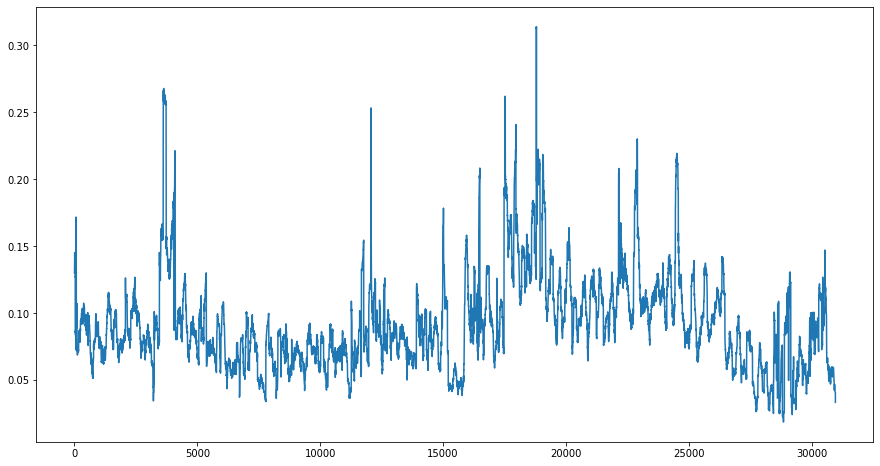

In [5]:
import matplotlib.pyplot  as plt
fig = plt.figure(figsize=(15,8))
plt.plot(y)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


lag = 30 # best reg.score: [72, 0.7540004648249765, 0.6328867862946501]

new_y = pd.concat((
    y,
    y.shift(lag).rename(columns={'realized_volatility':'lag_y'}),
    X['spread'].shift(lag),
    X['spread_sq'].shift(lag),
    X['BBAOFI'].shift(lag),        
    X['FDOFI'].shift(lag)
    ), axis=1).dropna()

y_=new_y['realized_volatility']
X_=new_y.drop(columns='realized_volatility')


reg = LinearRegression()
model = reg.fit(X=X_, y=y_)

joblib.dump(model,'model.joblib')



['model.joblib']

In [22]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

lag=30
new_y = pd.concat((
        y,
        y.shift(lag).rename(columns={'realized_volatility':'lag_y'}),
        X['spread'].shift(lag),
        X['spread_sq'].shift(lag),
        X['BBAOFI'].shift(lag),        
        X['FDOFI'].shift(lag),            
        ), axis=1).dropna()


pca = PCA(n_components=1)
pca.fit(new_y.values[:,1:])
X_emb = pca.transform(new_y.values[:,1:])
X_emb = np.concatenate((new_y.values[:,0].reshape(new_y.shape[0],-1),X_emb),axis=1)
new_y = pd.DataFrame(X_emb, columns=('volatility', 'predictors'))
gm = GaussianMixture(n_components=2, random_state=0).fit(new_y)
labels = gm.predict(new_y)
probs = gm.predict_proba(new_y)[:,0]

# labels=labels>0
print('0 :'+str(np.sum(labels==0)))
print('1 :'+str(np.sum(labels==1)))
print('2 :'+str(np.sum(labels==2)))
print('3 :'+str(np.sum(labels==3)))

new_y2 = pd.concat((new_y,pd.DataFrame({'labels':labels, 'probs':probs})), axis=1).dropna()
new_y2

joblib.dump(pca,'pca.joblib')
joblib.dump(gm,'gaussian_mixture.joblib')


0 :5572
1 :25363
2 :0
3 :0


['gaussian_mixture.joblib']

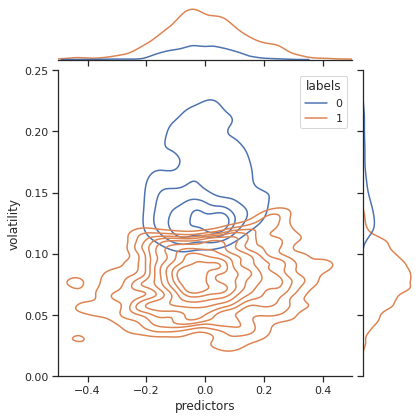

In [20]:
import seaborn as sns
sns.set_theme(style="ticks")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=new_y2,
    x="predictors", y="volatility", hue='labels',
    xlim=[-.5,.5],
    ylim=[0,.25],
    kind="kde",
)

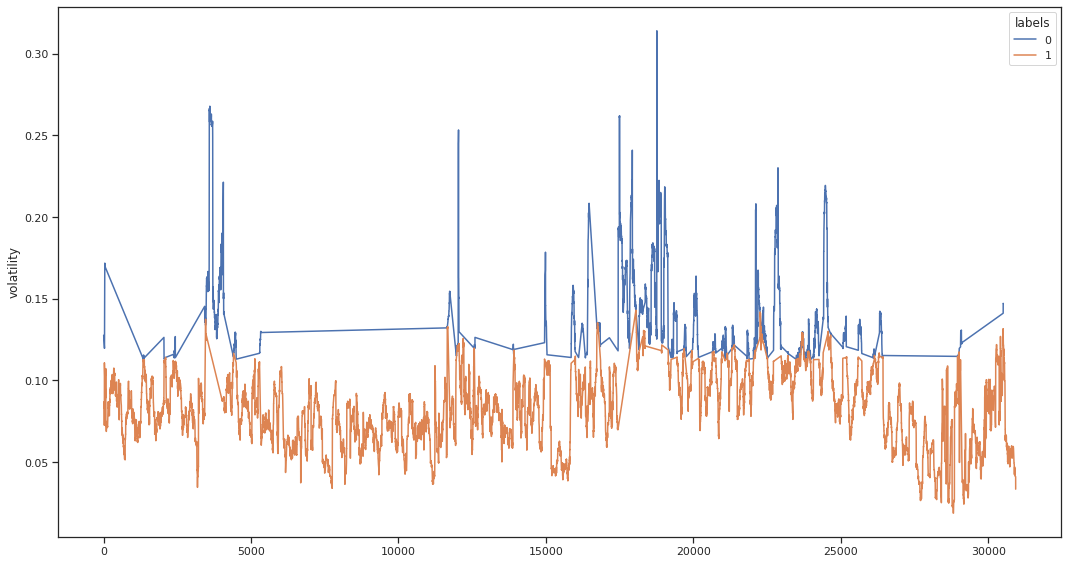

In [21]:
fig = plt.figure(figsize=(15,8))
sns.lineplot(data=new_y2, x = new_y2.index, y="volatility", hue='labels')
plt.tight_layout()